In [1]:
import os
import json
import sys

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from data_module.data_module import ALDataModule_v1
from model.classifier_model import Classifier1D
from model.AE_model import AECNN1DModel
from model.enc_classifier_model import AE1DClassifier

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tqdm.auto import tqdm

/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("-dn", "--data_number", type=int, default=8000,
                    help=f"Used for limit the number of data for tSNE Plot")

parser.add_argument("-ds", "--dataset_path", type=str, default="dataset/processed_concat_data_8_labels",
                    help=f"Original dataset path")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=[])
else:
    args = parser.parse_args()

In [78]:
label_list = ["still", "walking", "run", "bike", "car", "bus", "train", "subway"]

In [79]:
dataset_path = args.dataset_path
data_module = ALDataModule_v1(dataset_path=dataset_path, batch_size=512, prefix="torso_", postfix="_fft")


In [80]:
data = data_module._train_data
label = data_module._train_label
filter_data = data[:args.data_number]
filter_label = label[:args.data_number]

print(data.shape, label.shape)
print(filter_data.shape, filter_label.shape)


(62951, 6, 257) (62951,)
(8000, 6, 257) (8000,)


In [81]:
np.unique(data_module._train_label, return_counts=True)[1]

array([8000, 7999, 6952, 8000, 8000, 8000, 8000, 8000])

In [82]:
act_label = np.array(label_list[:len(np.unique(filter_label, return_counts=True)[1])])
act_label

array(['still', 'walking', 'run', 'bike', 'car', 'bus', 'train', 'subway'],
      dtype='<U7')

In [83]:
def get_tsne(train_data, n_components=2):
    data_1d = train_data.reshape(train_data.shape[0], -1)
    tsne = TSNE(n_components=n_components, verbose=0, perplexity=50, n_iter=500)

    tsne_results = tsne.fit_transform(data_1d)
    return tsne_results

def scatter_tsne(tsne_result, axis=None):
    assert tsne_result.shape[1] == 2
    scatter = sns.scatterplot(
        x=tsne_result[:,0], y=tsne_result[:,1],
        hue=filter_label.astype(np.int8),
        palette=sns.color_palette("hls", 8),
        legend="full",
        alpha=0.5,
        ax=axis,
    )
    return scatter

def scatter_3d_tsne(tsne_result):
    assert tsne_result.shape[1] == 3

    fig = plt.figure(figsize=(6,8))
    ax = fig.add_subplot(projection='3d')

    scatter1 = ax.scatter(tsne_result[:,0], tsne_result[:,1], tsne_result[:,2], c=filter_train_label-1, marker='o')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    print(scatter1.legend_elements()[0])
    ax.legend(*[scatter1.legend_elements()[0], act_label], 
                    title="Activity", loc='upper left')
    

(8000, 2)


Text(0.5, 1.0, 'The data distribution when using all 8 classes')

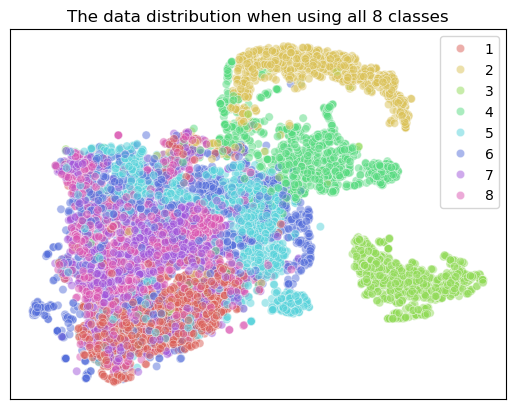

In [85]:
tsne_result = get_tsne(filter_data)
print(tsne_result.shape)
scatter_tsne(tsne_result)
plt.xticks([])
plt.yticks([])
plt.title("The data distribution when using all 8 classes")

(8000, 3)


NameError: name 'filter_train_label' is not defined

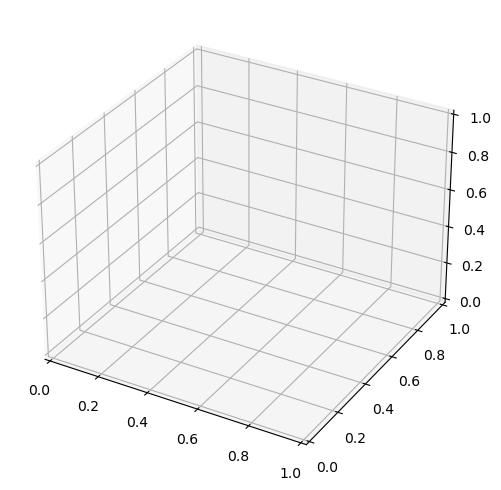

In [75]:
tsne_result = get_tsne(filter_data, n_components=3)
print(tsne_result.shape)
scatter_3d_tsne(tsne_result)

In [330]:
checkpoint_path = "/nfs/ksdata/tran/HAR_AE/lightning_logs/10_classify_5classes_10000data/version_4/checkpoints/sample_epoch=8159-step=163200-val_loss=0.107307.ckpt"
net = Classifier1D.load_from_checkpoint(checkpoint_path)

net

Classifier1D(
  (cnn): Sequential(
    (0): Conv1d(6, 32, kernel_size=(8,), stride=(3,))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv1d(32, 64, kernel_size=(8,), stride=(3,))
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=1664, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [90]:
def unwrap_model(model):
    layer = []
    def _unwrap_model(model):
        # nonlocal layer
        for i in model.children():
            if isinstance(i, nn.Sequential): _unwrap_model(i)
            else: layer.append(i)
    _unwrap_model(model)
    return layer

In [332]:
all_layers = unwrap_model(net)            
all_layers.insert(6, nn.Flatten())
print("分類器")
print(*list(enumerate(all_layers)), sep="\n")

分類器
(0, Conv1d(6, 32, kernel_size=(8,), stride=(3,)))
(1, ReLU())
(2, Dropout(p=0.5, inplace=False))
(3, Conv1d(32, 64, kernel_size=(8,), stride=(3,)))
(4, ReLU())
(5, Dropout(p=0.5, inplace=False))
(6, Flatten(start_dim=1, end_dim=-1))
(7, Linear(in_features=1664, out_features=256, bias=True))
(8, BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(9, ReLU())
(10, Linear(in_features=256, out_features=128, bias=True))
(11, BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(12, ReLU())
(13, Linear(in_features=128, out_features=5, bias=True))


In [299]:
take_output_layer = []
for layer in all_layers:
    if isinstance(layer, nn.Conv1d) or isinstance(layer, nn.Linear):
        take_output_layer.append(all_layers.index(layer))
# take_output_layer.append(len(all_layers) - 1)
take_output_layer

[0, 3, 7, 10, 13]

In [91]:

def get_layer_output(all_layers, layer_idx, pred_data_np):
    with torch.inference_mode():
        seq = nn.Sequential(*all_layers[:layer_idx + 1])
        seq.eval()
    
        out_tensor_list = []
        for data_idx in range(len(pred_data_np)):
            input_tensor = torch.Tensor(pred_data_np[data_idx]).unsqueeze(axis=0).to("cuda:0")
            out = seq(input_tensor)
            out_tensor_list.append(out)
    
        out_tensor = torch.cat(out_tensor_list)
    return out_tensor


In [301]:
out_tensor = get_layer_output(all_layers, layer_idx=0, pred_data_np=filter_data)
out_tensor.shape

torch.Size([5000, 32, 84])

In [302]:
tsne_list = []

for layer_idx in tqdm(range(len(take_output_layer))):
    output_tensor = get_layer_output(all_layers, layer_idx=take_output_layer[layer_idx], pred_data_np=filter_data)
    output_np = output_tensor.cpu().numpy()

    tsne_result = get_tsne(output_np)
    tsne_list.append(tsne_result)
    # scatter_tsne(tsne_result, axis=axs[layer_idx])
    

100%|██████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.32s/it]


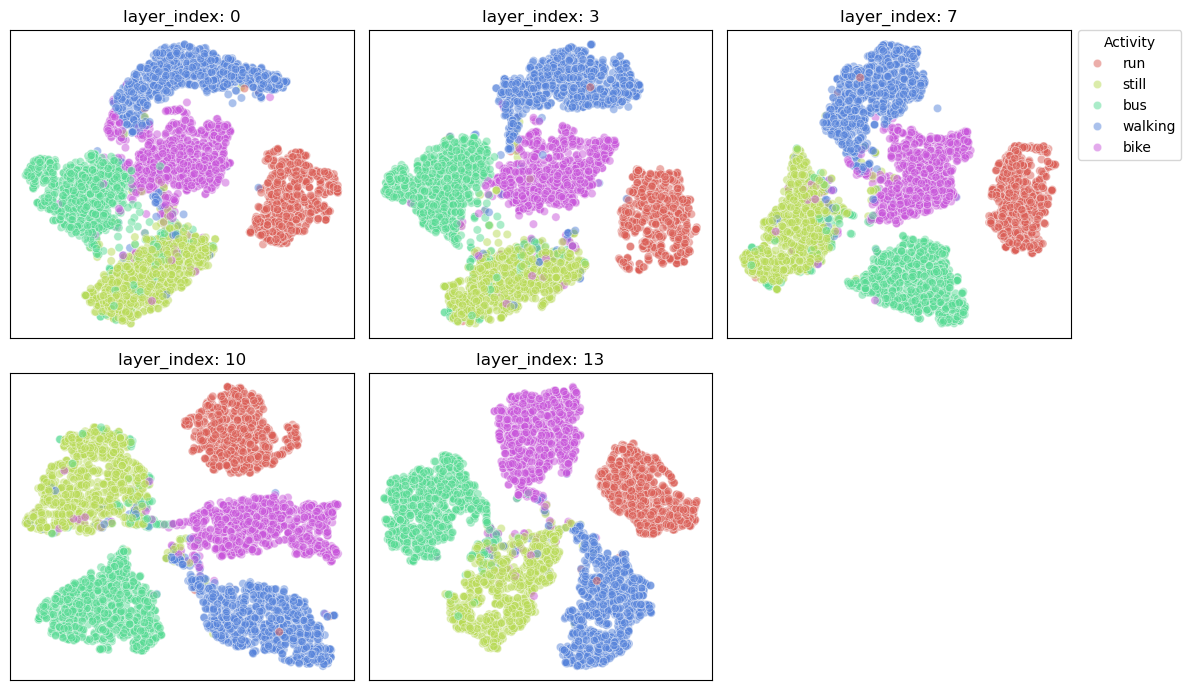

In [308]:
COL = 3
ROW = int(np.ceil(len(take_output_layer)/COL))
fig, axs = plt.subplots(ROW, COL, figsize=(12, 7))

for layer_idx in range(COL * ROW):
    r = layer_idx % COL
    c = layer_idx // COL
    ax = axs[c, r]
    if layer_idx > len(take_output_layer) - 1:
        ax.set_visible(False)
        continue
    scatter = scatter_tsne(tsne_list[layer_idx], axis=axs[c, r])
    ax.title.set_text(f"layer_index: {take_output_layer[layer_idx]}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend().set_visible(False)

    if layer_idx == COL - 1:
        ax.legend(title="Activity", loc="upper left", bbox_to_anchor=(1.02, 1.0,), borderaxespad=0)
    

plt.tight_layout()

In [325]:
checkpoint_path = "/nfs/ksdata/tran/HAR_AE/lightning_logs/11_AE_5classes_10000data/version_0/checkpoints/sample_epoch=4009-step=80200-val_loss=0.000000.ckpt"
net = AECNN1DModel.load_from_checkpoint(checkpoint_path)

net

AECNN1DModel(
  (enc_cnn): Sequential(
    (0): Conv1d(6, 32, kernel_size=(8,), stride=(3,))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv1d(32, 64, kernel_size=(8,), stride=(3,))
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (enc_linear): Sequential(
    (0): Linear(in_features=1664, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (dec_linear): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1664, bias=True)
  )
  (dec_cnn): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(8,), stride=(3,), output_padding=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(32, 6, kernel_size=(8,), stride=(3,))
    (3): ReLU()
  )
)

In [326]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [329]:
all_layers = unwrap_model(net)  

all_layers.insert(13, Reshape(-1, 64, 26))
all_layers.insert(6, nn.Flatten())
print("AutoEncoder")
print(*list(enumerate(all_layers)), sep="\n")

AutoEncoder
(0, Conv1d(6, 32, kernel_size=(8,), stride=(3,)))
(1, ReLU())
(2, Dropout(p=0.5, inplace=False))
(3, Conv1d(32, 64, kernel_size=(8,), stride=(3,)))
(4, ReLU())
(5, Dropout(p=0.5, inplace=False))
(6, Flatten(start_dim=1, end_dim=-1))
(7, Linear(in_features=1664, out_features=256, bias=True))
(8, ReLU())
(9, Linear(in_features=256, out_features=128, bias=True))
(10, ReLU())
(11, Linear(in_features=128, out_features=256, bias=True))
(12, ReLU())
(13, Linear(in_features=256, out_features=1664, bias=True))
(14, Reshape())
(15, ConvTranspose1d(64, 32, kernel_size=(8,), stride=(3,), output_padding=(1,)))
(16, ReLU())
(17, ConvTranspose1d(32, 6, kernel_size=(8,), stride=(3,)))
(18, ReLU())


In [312]:
take_output_layer = []
for layer in all_layers:
    if isinstance(layer, nn.Conv1d) or isinstance(layer, nn.Linear) or isinstance(layer, nn.ConvTranspose1d):
        take_output_layer.append(all_layers.index(layer))
# take_output_layer.append(len(all_layers) - 1)
take_output_layer

[0, 3, 7, 9, 11, 13, 15, 17]

In [313]:
tsne_list = []

for layer_idx in tqdm(range(len(take_output_layer))):
    output_tensor = get_layer_output(all_layers, layer_idx=take_output_layer[layer_idx], pred_data_np=filter_data)
    output_np = output_tensor.cpu().numpy()

    tsne_result = get_tsne(output_np)
    tsne_list.append(tsne_result)
    # scatter_tsne(tsne_result, axis=axs[layer_idx])
    

100%|██████████████████████████████████████████████████████████████| 8/8 [01:11<00:00,  8.93s/it]


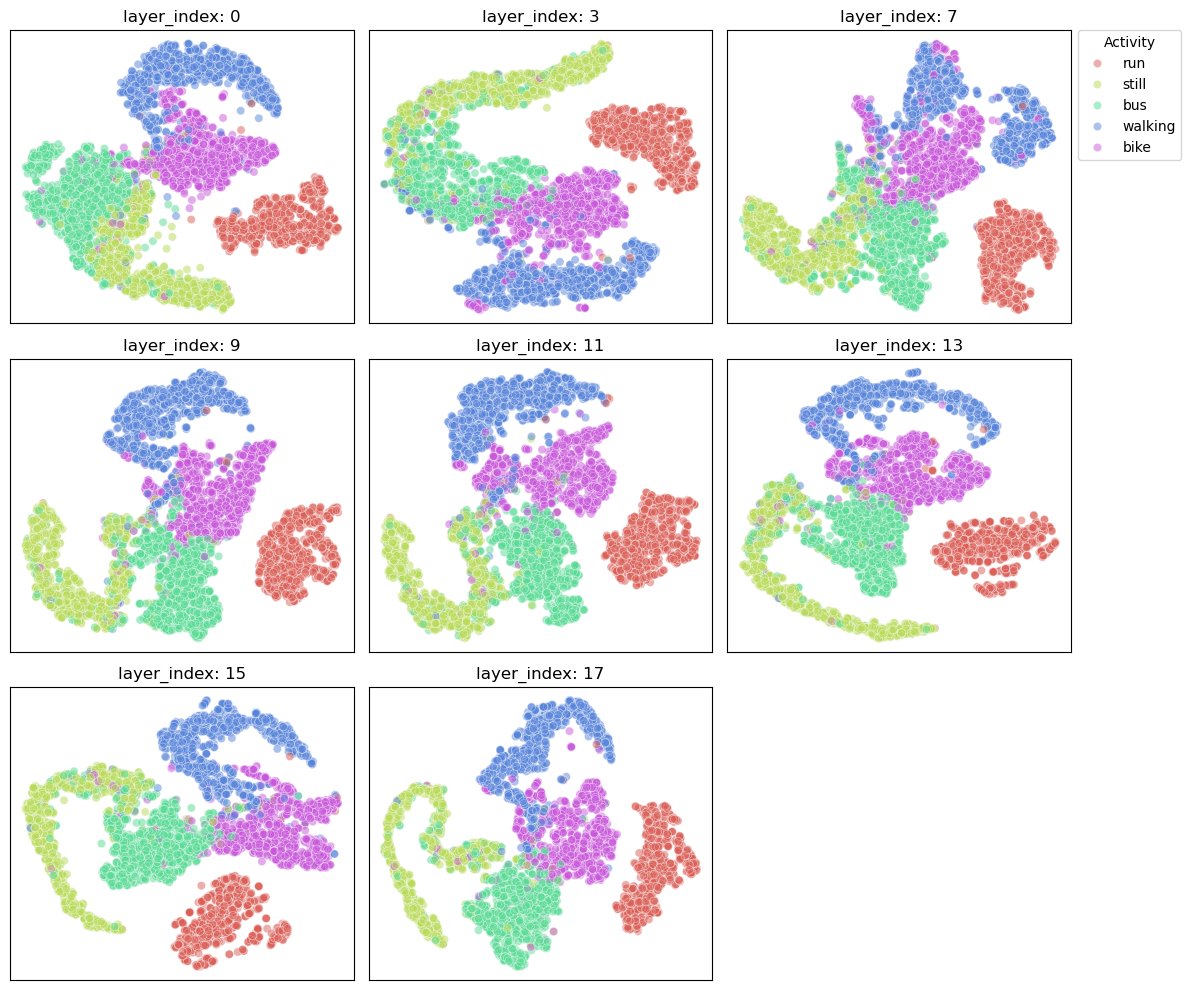

In [316]:
COL = 3
ROW = int(np.ceil(len(take_output_layer)/COL))
fig, axs = plt.subplots(ROW, COL, figsize=(12, 10))

for layer_idx in range(COL * ROW):
    r = layer_idx % COL
    c = layer_idx // COL
    ax = axs[c, r]
    if layer_idx > len(take_output_layer) - 1:
        ax.set_visible(False)
        continue
    scatter = scatter_tsne(tsne_list[layer_idx], axis=axs[c, r])
    ax.title.set_text(f"layer_index: {take_output_layer[layer_idx]}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend().set_visible(False)

    if layer_idx == COL - 1:
        ax.legend(title="Activity", loc="upper left", bbox_to_anchor=(1.02, 1.0,), borderaxespad=0)
    

plt.tight_layout()

In [339]:
checkpoint_path = "lightning_logs/15_enc_classify_5classes/pattern_0/version_2/checkpoints/sample_epoch=419-step=8400-val_loss=0.153993.ckpt"

net = AE1DClassifier.load_from_checkpoint(checkpoint_path)

In [359]:
# net

In [365]:
all_layers = unwrap_model(net)[1:]

all_layers.insert(6, nn.Flatten())
print("Encoder Classifier")
print(*list(enumerate(all_layers)), sep="\n")

Encoder Classifier
(0, Conv1d(6, 32, kernel_size=(8,), stride=(3,)))
(1, ReLU())
(2, Dropout(p=0.5, inplace=False))
(3, Conv1d(32, 64, kernel_size=(8,), stride=(3,)))
(4, ReLU())
(5, Dropout(p=0.5, inplace=False))
(6, Flatten(start_dim=1, end_dim=-1))
(7, Linear(in_features=1664, out_features=256, bias=True))
(8, ReLU())
(9, Linear(in_features=256, out_features=128, bias=True))
(10, ReLU())
(11, Linear(in_features=128, out_features=128, bias=True))
(12, BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(13, ReLU())
(14, Linear(in_features=128, out_features=64, bias=True))
(15, BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(16, ReLU())
(17, Linear(in_features=64, out_features=5, bias=True))


In [366]:
take_output_layer = []
for layer in all_layers:
    if isinstance(layer, nn.Conv1d) or isinstance(layer, nn.Linear) or isinstance(layer, nn.ConvTranspose1d):
        take_output_layer.append(all_layers.index(layer))
# take_output_layer.append(len(all_layers) - 1)
take_output_layer

[0, 3, 7, 9, 11, 14, 17]

In [367]:
tsne_list = []

for layer_idx in tqdm(range(len(take_output_layer))):
    output_tensor = get_layer_output(all_layers, layer_idx=take_output_layer[layer_idx], pred_data_np=filter_data)
    output_np = output_tensor.cpu().numpy()

    tsne_result = get_tsne(output_np)
    tsne_list.append(tsne_result)
    # scatter_tsne(tsne_result, axis=axs[layer_idx])
    

100%|██████████████████████████████████████████████████████████████| 7/7 [00:58<00:00,  8.37s/it]


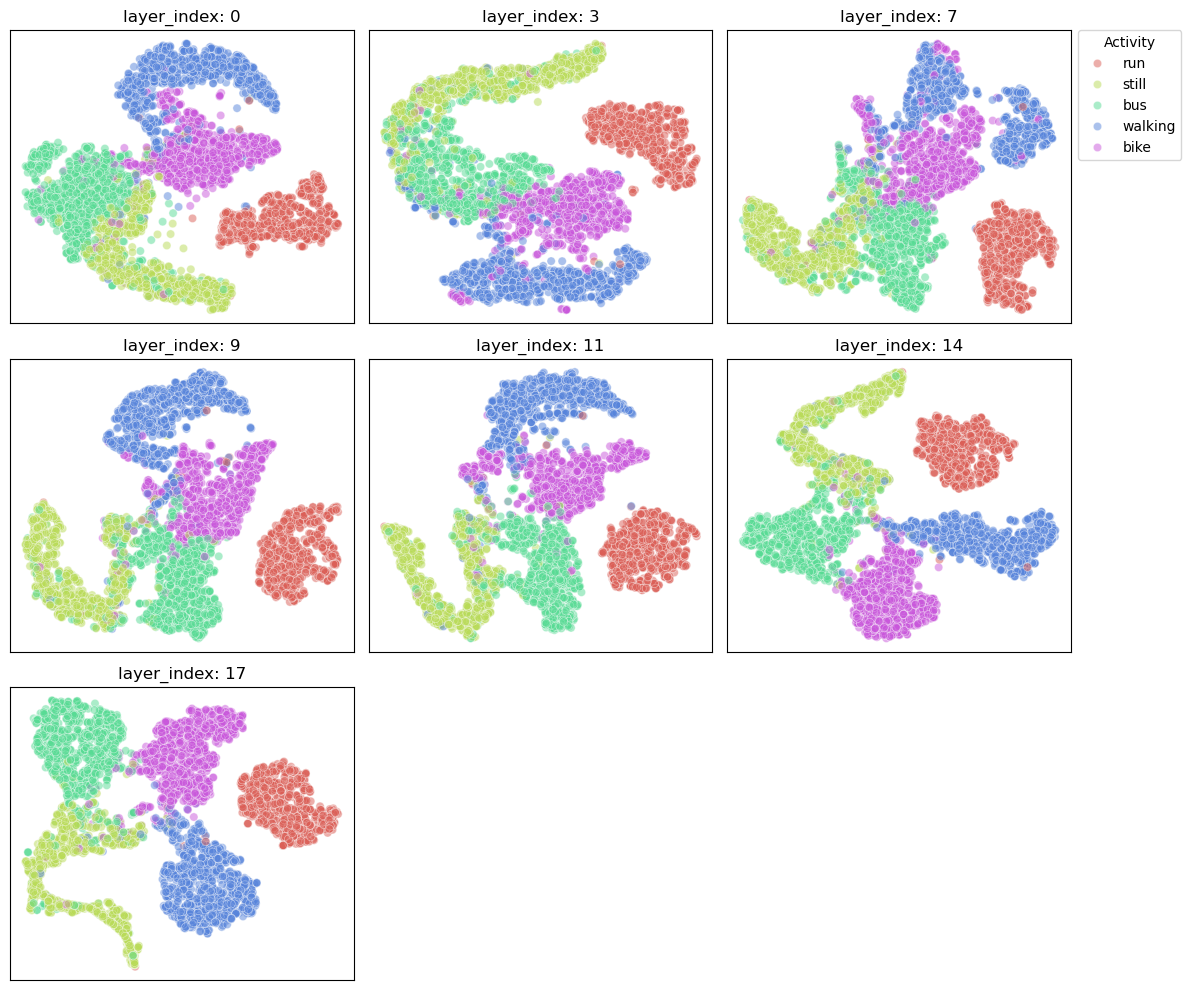

In [368]:
COL = 3
ROW = int(np.ceil(len(take_output_layer)/COL))
fig, axs = plt.subplots(ROW, COL, figsize=(12, 10))

for layer_idx in range(COL * ROW):
    r = layer_idx % COL
    c = layer_idx // COL
    ax = axs[c, r]
    if layer_idx > len(take_output_layer) - 1:
        ax.set_visible(False)
        continue
    scatter = scatter_tsne(tsne_list[layer_idx], axis=axs[c, r])
    ax.title.set_text(f"layer_index: {take_output_layer[layer_idx]}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend().set_visible(False)

    if layer_idx == COL - 1:
        ax.legend(title="Activity", loc="upper left", bbox_to_anchor=(1.02, 1.0,), borderaxespad=0)

plt.tight_layout()

In [88]:
checkpoint_path = "/nfs/ksdata/tran/HAR_AE/lightning_logs/10.3_classify_8classes_10000data/version_4/checkpoints/sample_epoch=19639-step=78560-val_loss=0.385121.ckpt"

net = Classifier1D.load_from_checkpoint(checkpoint_path)

In [92]:
all_layers = unwrap_model(net)            
all_layers.insert(6, nn.Flatten())
print("分類器")
print(*list(enumerate(all_layers)), sep="\n")

分類器
(0, Conv1d(6, 32, kernel_size=(8,), stride=(3,)))
(1, ReLU())
(2, Dropout(p=0.5, inplace=False))
(3, Conv1d(32, 64, kernel_size=(8,), stride=(3,)))
(4, ReLU())
(5, Dropout(p=0.5, inplace=False))
(6, Flatten(start_dim=1, end_dim=-1))
(7, Linear(in_features=1664, out_features=256, bias=True))
(8, BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(9, ReLU())
(10, Linear(in_features=256, out_features=128, bias=True))
(11, BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(12, ReLU())
(13, Linear(in_features=128, out_features=8, bias=True))


In [93]:
take_output_layer = []
for layer in all_layers:
    if isinstance(layer, nn.Conv1d) or isinstance(layer, nn.Linear):
        take_output_layer.append(all_layers.index(layer))
# take_output_layer.append(len(all_layers) - 1)
take_output_layer

[0, 3, 7, 10, 13]

In [95]:
tsne_list = []

for layer_idx in tqdm(range(len(take_output_layer))):
    output_tensor = get_layer_output(all_layers, layer_idx=take_output_layer[layer_idx], pred_data_np=filter_data)
    output_np = output_tensor.cpu().numpy()

    tsne_result = get_tsne(output_np)
    tsne_list.append(tsne_result)
    # scatter_tsne(tsne_result, axis=axs[layer_idx])
    

100%|█████████████████████████████████████████| 5/5 [01:11<00:00, 14.30s/it]


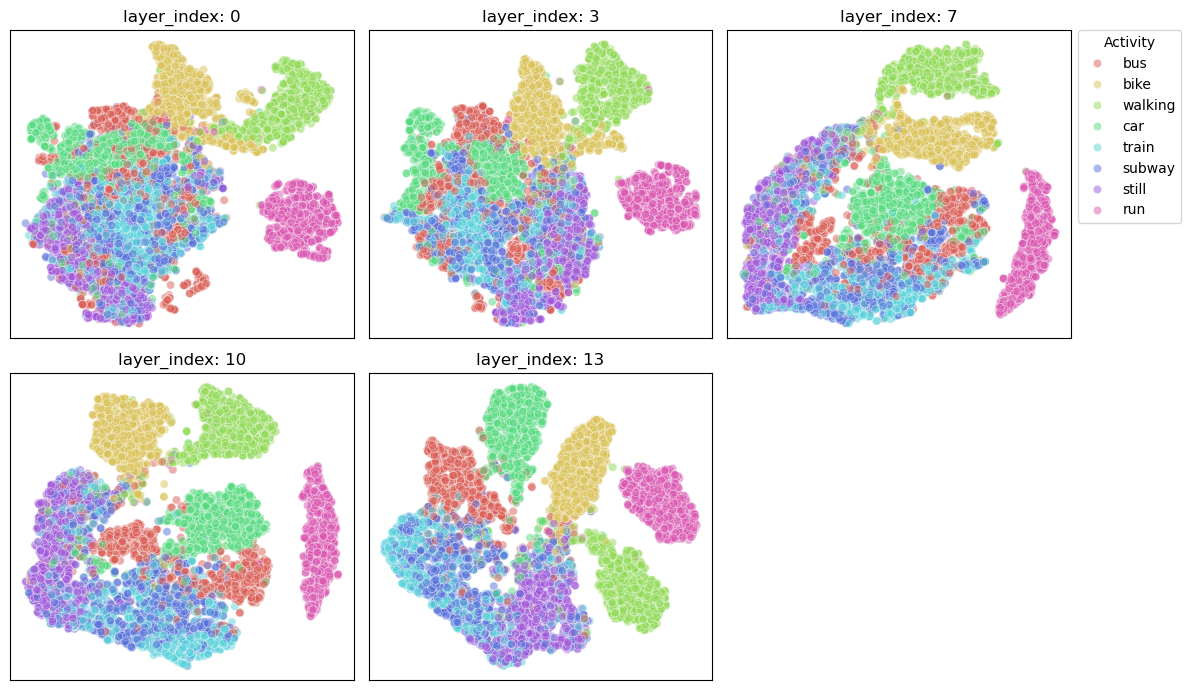

In [96]:
COL = 3
ROW = int(np.ceil(len(take_output_layer)/COL))
fig, axs = plt.subplots(ROW, COL, figsize=(12, 7))

for layer_idx in range(COL * ROW):
    r = layer_idx % COL
    c = layer_idx // COL
    ax = axs[c, r]
    if layer_idx > len(take_output_layer) - 1:
        ax.set_visible(False)
        continue
    scatter = scatter_tsne(tsne_list[layer_idx], axis=axs[c, r])
    ax.title.set_text(f"layer_index: {take_output_layer[layer_idx]}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend().set_visible(False)

    if layer_idx == COL - 1:
        ax.legend(title="Activity", loc="upper left", bbox_to_anchor=(1.02, 1.0,), borderaxespad=0)
    

plt.tight_layout()